In [23]:
import pandas as pd
import numpy as np
import joblib
import os
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, roc_curve, PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder
from datetime import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Load and prepare data
clinical_df = pd.read_csv("../data/processed/train_ready/clinical_df_v1.csv", parse_dates=['timestamp'])
clinical_df.sort_values(['timestamp', 'patient_id'], inplace=True)
clinical_df.dropna(inplace=True)
clinical_df.drop(columns=['Unnamed: 0'], inplace=True)

In [24]:
clinical_df.head()

,timestamp,puffs,district,longitude,latitude,station,PM2.5 (µg/m³),NO2 (µg/m³),O3 (µg/m³),patient_id,gender,age,home_district,gema_severity,work_district,symbicort_adherence,hour,is_night,is_peak_pollution,24h_puffs,puffs_6h_diff,3d_PM25_avg,24h_PM25_avg,24h_NO2_avg,24h_O3_avg,PM25_exceedance,NO2_exceedance,O3_exceedance,hospitalization,gema_risk_score,district_risk
71,2024-01-03 23:00:00,1.0,Sant Marti,2.189396,41.399597,4.0,9.0,38.00,51.0,PAT-0000,F,76,Sant Marti,Moderate Persistent,Horta-Guinardo,0.410187,23,0,0,1.0,1.0,7.706250,7.789583,23.833333,47.635417,0,1,0,0,1.579626,0.123995
8831,2024-01-03 23:00:00,0.0,Sants-Montjuic,2.133575,41.362611,42.0,9.0,36.00,51.0,PAT-0001,M,50,Sants-Montjuic,Intermittent,Gracia,0.698253,23,0,0,2.0,0.0,8.324653,7.996875,37.320417,35.264583,0,1,0,0,0.501747,0.155943
17591,2024-01-03 23:00:00,0.0,Sants-Montjuic,2.131555,41.361083,42.0,9.0,36.00,51.0,PAT-0002,M,45,Sants-Montjuic,Mild Persistent,Sants-Montjuic,0.917523,23,0,0,2.0,0.0,8.115069,8.337292,41.750000,48.052083,0,1,0,0,0.423715,0.155943
26351,2024-01-03 23:00:00,0.0,Sant Marti,2.191570,41.400107,4.0,9.0,38.00,51.0,PAT-0003,F,51,Sant Marti,Intermittent,Sant Marti,0.795053,23,0,0,1.0,0.0,8.281736,8.545625,34.500000,48.093750,0,1,0,0,0.404947,0.123995
35111,2024-01-03 23:00:00,0.0,Les Corts,2.132419,41.385499,57.0,6.1,27.91,29.3,PAT-0004,M,56,Les Corts,Mild Persistent,Les Corts,0.400000,23,0,0,3.0,0.0,8.837500,5.279167,21.969167,40.116667,0,1,0,0,1.200000,0.151566


### Feature Engineering

In [25]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Create target: hospitalization in next 6-12 hours
clinical_df = clinical_df.sort_values(['patient_id', 'timestamp'])

# Shift hacia adelante entre 6 y 12 horas (asumiendo frecuencia horaria)
clinical_df['target'] = clinical_df.groupby('patient_id')['hospitalization'].shift(-6) 
clinical_df['target'] = clinical_df.groupby('patient_id')['target'].transform(
    lambda x: x.rolling(6, min_periods=1).max()  
)

# Drop target rows
clinical_df.dropna(subset=['target'], inplace=True)
clinical_df['target'] = clinical_df['target'].astype(int)

# 2. Categorical features treatment
# Gender (binary encoding)
clinical_df['gender_encoded'] = clinical_df['gender'].map({'F': 0, 'M': 1})

# Gema_severity (ordinal encoding)
ordinal_encoder = OrdinalEncoder(categories=[clinical_df['gema_severity'].unique()])
clinical_df['gema_severity_encoded'] = ordinal_encoder.fit_transform(clinical_df[['gema_severity']])

### Temporal Data Split: Under-Sampling

In [26]:
from sklearn.utils import resample

# Key features
features = ['puffs', 'PM2.5 (µg/m³)', 'NO2 (µg/m³)', 'O3 (µg/m³)',
       'gender_encoded', 'age', 'gema_severity_encoded', 'symbicort_adherence', 'hour', 'is_night', 
       'is_peak_pollution','24h_puffs', 'puffs_6h_diff', '3d_PM25_avg', '24h_PM25_avg',
       '24h_NO2_avg', '24h_O3_avg', 'PM25_exceedance', 'NO2_exceedance',
       'O3_exceedance', 'gema_risk_score', 'district_risk'
]

# 2. Define grouping variable (patients) and time threshold
TEST_SIZE = 0.2
TIME_CUTOFF = clinical_df['timestamp'].quantile(1-TEST_SIZE)

# 3. Temporal split - latest 20% period for test
test = clinical_df[clinical_df['timestamp'] >= TIME_CUTOFF]
train = clinical_df[clinical_df['timestamp'] < TIME_CUTOFF]

# 4. Balance training set (only on train data)
train_pos = train[train['target'] == 1]
train_neg = train[train['target'] == 0]

# Upsample positives to match 30% prevalence
desired_ratio = 0.3  # 30% positive class
n_pos = len(train_pos)
n_neg = int(n_pos * (1 - desired_ratio) / desired_ratio)
train_neg_balanced = resample(train_neg, n_samples=n_neg, replace=False, random_state=42)

train_balanced = pd.concat([train_pos, train_neg_balanced]).sample(frac=1, random_state=42)

# 5. Final validation split (time-based within train)
train_cutoff = train_balanced['timestamp'].quantile(0.8)
val = train_balanced[train_balanced['timestamp'] > train_cutoff]
train_final = train_balanced[train_balanced['timestamp'] <= train_cutoff]

print(f""" Data Split Summary: 
      - Training: {len(train_final)} samples ({len(train_final['patient_id'].unique())} patients)
      - Validation: {len(val)} samples ({len(val['patient_id'].unique())} patients)
      - Test: {len(test)} samples ({len(test['patient_id'].unique())} patients)

Class Distribution:
Training: {train_final['target'].value_counts(normalize=True).to_dict()}
Validation: {val['target'].value_counts(normalize=True).to_dict()}
Test: {test['target'].value_counts(normalize=True).to_dict()}
""")

 Data Split Summary: 
      - Training: 2912 samples (50 patients)
      - Validation: 728 samples (50 patients)
      - Test: 60044 samples (50 patients)

Class Distribution:
Training: {0: 0.7015796703296703, 1: 0.29842032967032966}
Validation: {0: 0.6936813186813187, 1: 0.30631868131868134}
Test: {0: 0.9909399773499433, 1: 0.009060022650056626}



### Gradient Boosting

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, PrecisionRecallDisplay, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, fbeta_score
import seaborn as sns
import numpy as np

# 1. Configurate model parameters
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'average_precision',  # AUPRC for imbalanced data
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'scale_pos_weight': train_final['target'].value_counts()[0] / train_final['target'].value_counts()[1],  
    'seed': 42,
    'verbosity': -1
}

# 3. Create LightGBM Dataset with validation
train_data = lgb.Dataset(train_final[features], label=train_final['target'],feature_name=features, free_raw_data=False)

val_data = lgb.Dataset(val[features], label=val['target'],reference=train_data, free_raw_data=False)

# 4. Training with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ],
    num_boost_round=1000
)

# 5. Test evaluation
y_test_pred = model.predict(test[features])

precisions, recalls, thresholds = precision_recall_curve(test['target'], y_test_pred)
target_recall = 0.90
mask = recalls[:-1] >= target_recall 

if np.any(mask):
    optimal_idx = np.where(mask)[0][-1]  
    optimal_threshold = thresholds[optimal_idx]
else:
    optimal_idx = np.argmax(recalls)
    optimal_threshold = thresholds[optimal_idx]

y_test_class = (y_test_pred >= optimal_threshold).astype(int)

# 6. Key metrics
print("\nTest Evaluation:")
print(classification_report(test['target'], y_test_class, target_names=['No Hospitalization', 'Hospitalization']))

print(f"\nAUPRC: {average_precision_score(test['target'], y_test_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(test['target'], y_test_pred):.3f}")
print(f"Optimal threshold: {optimal_threshold}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's average_precision: 0.989259

Test Evaluation:
                    precision    recall  f1-score   support

No Hospitalization       1.00      0.98      0.99     59500
   Hospitalization       0.33      0.90      0.49       544

          accuracy                           0.98     60044
         macro avg       0.67      0.94      0.74     60044
      weighted avg       0.99      0.98      0.99     60044


AUPRC: 0.665
ROC-AUC: 0.994
Optimal threshold: 0.7567520356514807


### Model Evaluation

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, PrecisionRecallDisplay, confusion_matrix
import seaborn as sns
import numpy as np

def plot_evaluation_metrics(test_target, y_prob, y_pred, model, figsize=(20, 16)):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    
    # 1. ROC-AUC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    fpr, tpr, _ = roc_curve(test_target, y_prob)
    roc_auc = roc_auc_score(test_target, y_prob)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
            xlabel='False Positive Rate',
            ylabel='True Positive Rate',
            title='Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    # 2. Precision-Recall Curve
    ax2 = fig.add_subplot(gs[0, 1])
    PrecisionRecallDisplay.from_predictions(
        test_target,
        y_prob,
        name="Model",
        plot_chance_level=True,
        chance_level_kw={"color": "red", "linestyle": "--"},
        ax=ax2
    )
    ax2.set(title="Precision-Recall Curve")
    ax2.grid(True)

    # 3. Confusion Matrix
    ax3 = fig.add_subplot(gs[1, 0])
    cm = confusion_matrix(test_target, y_pred)
    sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
                annot_kws={'size': 12},
                cbar=False,
                xticklabels=['No Hosp', 'Hosp'],
                yticklabels=['No Hosp', 'Hosp'],
                ax=ax3)
    ax3.set(title='Confusion Matrix',
           xlabel='Preds',
           ylabel='True')

    """
    # 4. Feature Importance
    ax4 = fig.add_subplot(gs[1, 1])
    importance = model.feature_importance(importance_type='gain')
    feature_names = model.feature_name()
    
    # Sort features by importance
    sorted_idx = np.argsort(importance)[::-1]  # Fix: Descending order
    sorted_names = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]
    
    # Plot top 10 features
    n_top = min(10, len(sorted_importance))  # Prevent overflow
    ax4.barh(range(n_top), sorted_importance[:n_top][::-1], 
            align='center', color='#1f77b4')
    ax4.set_yticks(range(n_top))
    ax4.set_yticklabels(sorted_names[:n_top][::-1])
    ax4.set(title='Top 10 Features by Importance',
           xlabel='Average Gain')
    """
    
    plt.tight_layout()
    plt.show()

# Use
plot_evaluation_metrics(test['target'], y_test_pred, y_test_class, model)

NameError: name 'y_test_pred' is not defined

### Data Split: SMOTE 

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 1. Temporal split (preserve time order)
split_idx = int(len(clinical_df) * 0.7)
train_val = clinical_df.iloc[:split_idx]
test = clinical_df.iloc[split_idx:]

# 2. Split train_val into train/validation
train, val = train_test_split(
    train_val,
    test_size=0.2, 
    stratify=train_val['target'],
    random_state=42
)

# 3. Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(
    train[features], 
    train['target']
)

# 4. Prepare final datasets
train_final = pd.DataFrame(X_train_res, columns=features)
train_final['target'] = y_train_res

# 5. Print summary with validation
print(f""" Data Split Summary:
      - Training: {len(train_final)} samples ({train_final['target'].value_counts().to_dict()})
      - Validation: {len(val)} samples ({val['target'].value_counts().to_dict()})
      - Test: {len(test)} samples ({test['target'].value_counts().to_dict()})

Class Distribution (%):
Training: {train_final['target'].value_counts(normalize=True).to_dict()}
Validation: {val['target'].value_counts(normalize=True).to_dict()}
Test: {test['target'].value_counts(normalize=True).to_dict()}
""")

/home/ivanseldasp/anaconda3/envs/asthma-realtime-py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 Data Split Summary:
      - Training: 333610 samples ({0: 166805, 1: 166805})
      - Validation: 42020 samples ({0: 41702, 1: 318})
      - Test: 90043 samples ({0: 89999, 1: 44})

Class Distribution (%):
Training: {0: 0.5, 1: 0.5}
Validation: {0: 0.9924321751546883, 1: 0.007567824845311756}
Test: {0: 0.9995113445798118, 1: 0.0004886554201881323}



In [9]:
# LightGBM Dataset with validation
train_data = lgb.Dataset(train_final[features], label=train_final['target'],feature_name=features, free_raw_data=False)
val_data = lgb.Dataset(val[features], label=val['target'],reference=train_data, free_raw_data=False)

# 4. Training with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ],
    num_boost_round=1000
)

# 5. Test evaluation
y_test_pred = model.predict(test[features])

precisions, recalls, thresholds = precision_recall_curve(test['target'], y_test_pred)
target_recall = 0.90
mask = recalls[:-1] >= target_recall 

if np.any(mask):
    optimal_idx = np.where(mask)[0][-1]  
    optimal_threshold = thresholds[optimal_idx]
else:
    optimal_idx = np.argmax(recalls)
    optimal_threshold = thresholds[optimal_idx]

y_test_class = (y_test_pred >= optimal_threshold).astype(int)

# 6. Key metrics
print("\nTest Evaluation:")
print(classification_report(test['target'], y_test_class, target_names=['No Hospitalization', 'Hospitalization']))

print(f"\nAUPRC: {average_precision_score(test['target'], y_test_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(test['target'], y_test_pred):.3f}")
print(f"Optimal threshold: {optimal_threshold}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's average_precision: 0.769533
[200]	valid_0's average_precision: 0.810568
[300]	valid_0's average_precision: 0.834899
[400]	valid_0's average_precision: 0.847626
[500]	valid_0's average_precision: 0.859265
[600]	valid_0's average_precision: 0.868802
[700]	valid_0's average_precision: 0.876565
[800]	valid_0's average_precision: 0.884746
[900]	valid_0's average_precision: 0.890607
[1000]	valid_0's average_precision: 0.894466
Did not meet early stopping. Best iteration is:
[997]	valid_0's average_precision: 0.894524

Test Evaluation:
                    precision    recall  f1-score   support

No Hospitalization       1.00      0.97      0.99     89999
   Hospitalization       0.02      0.91      0.03        44

          accuracy                           0.97     90043
         macro avg       0.51      0.94      0.51     90043
      weighted avg       1.00      0.97      0.99     90043


AUPRC: 0.239
ROC-AUC: 0.

/tmp/ipykernel_1394/4095124493.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


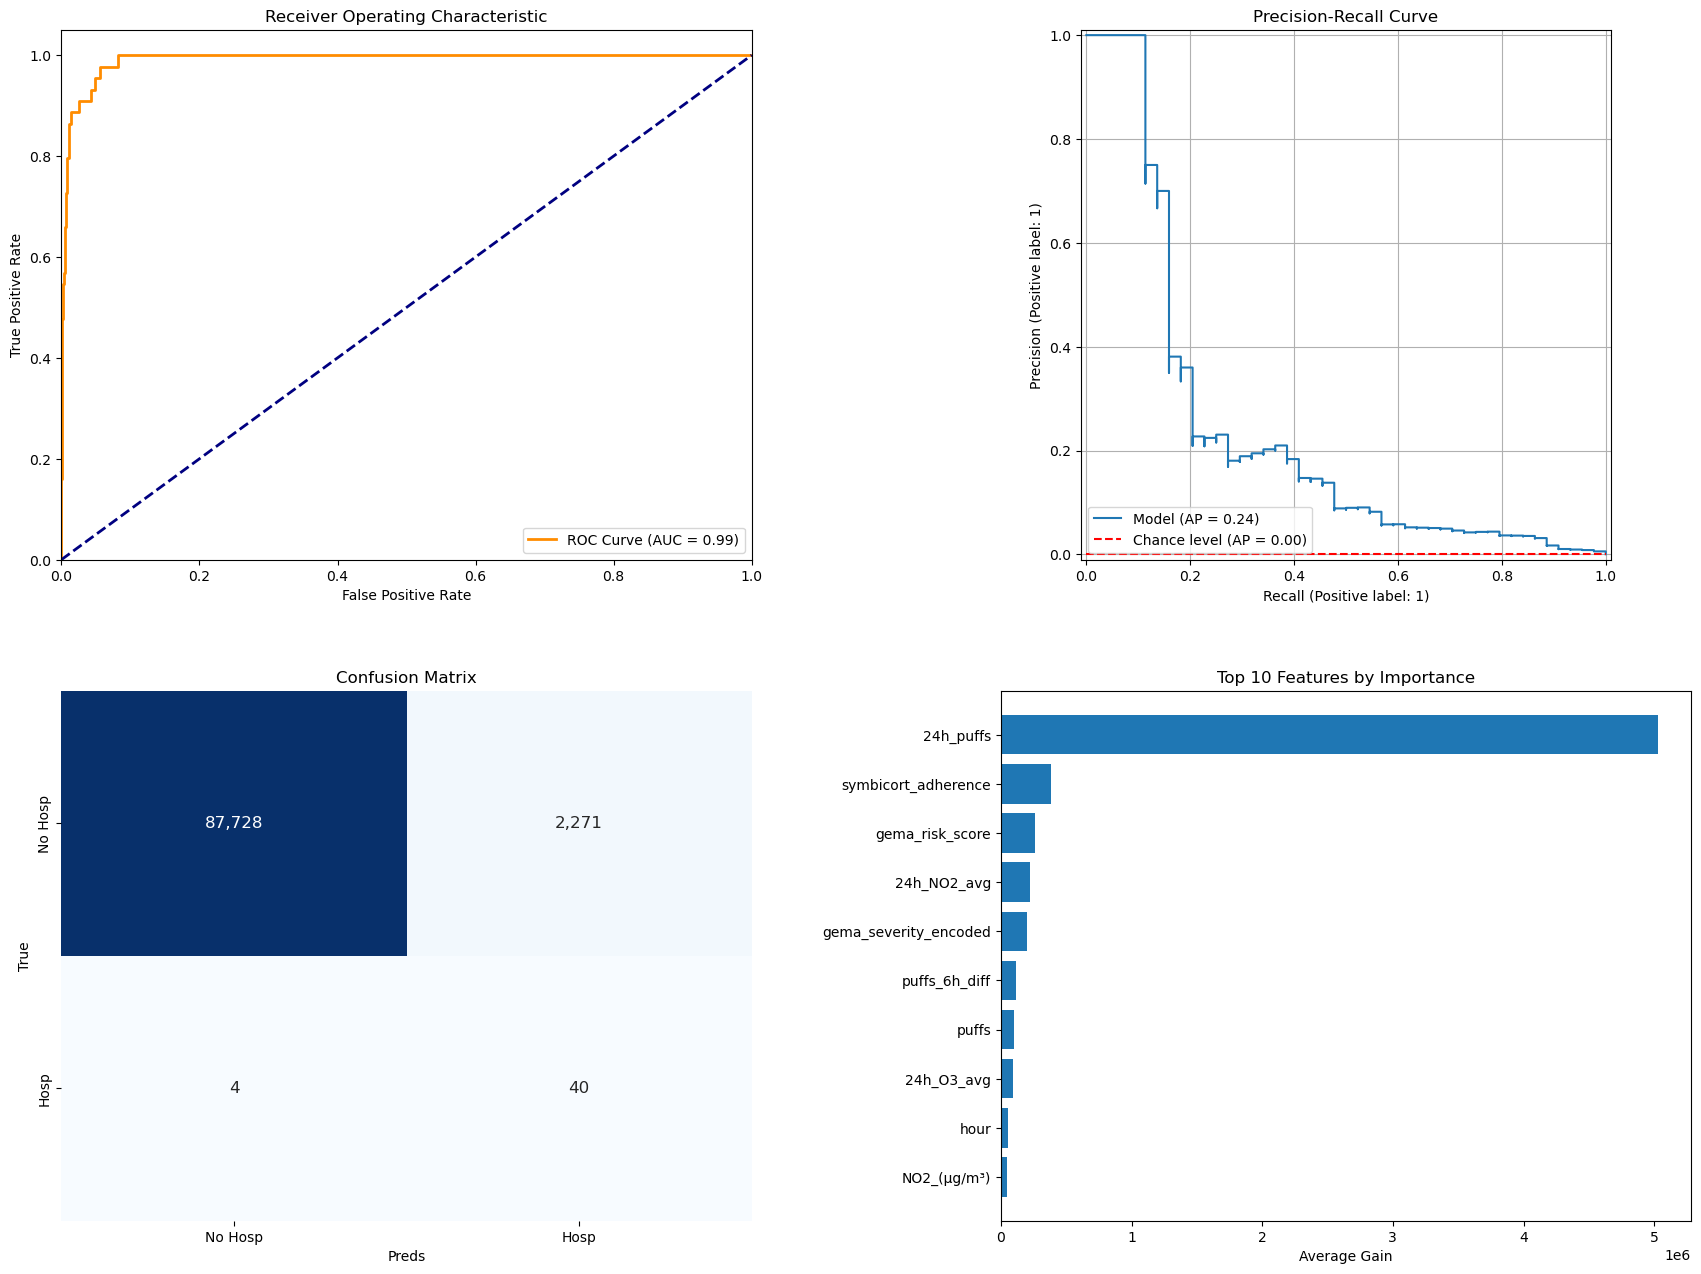

In [10]:
plot_evaluation_metrics(test['target'], y_test_pred, y_test_class, model)

### Neural Network: Tensorflow Classification

In [29]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import numpy as np

In [30]:
scaler = StandardScaler()
X_train, y_train = scaler.fit_transform(train_final[features]), train_final['target']
X_test, y_test = scaler.transform(test[features]), test['target']

In [31]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(8, activation='relu'),  # Hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2  # 20% of training data used for validation
)

# Evaluate on test data
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)  # Order matches metrics list
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")  # Optional

Epoch 1/20


/home/ivanseldasp/anaconda3/envs/asthma-realtime-py39/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8341/8341 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9646 - loss: 0.1080 - precision: 0.9497 - recall: 0.9551 - val_accuracy: 0.9860 - val_loss: 0.0479 - val_precision: 1.0000 - val_recall: 0.9860
Epoch 2/20
8341/8341 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9853 - loss: 0.0440 - precision: 0.9740 - recall: 0.9871 - val_accuracy: 0.9872 - val_loss: 0.0426 - val_precision: 1.0000 - val_recall: 0.9872
Epoch 3/20
8341/8341 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9871 - loss: 0.0401 - precision: 0.9758 - recall: 0.9901 - val_accuracy: 0.9945 - val_loss: 0.0264 - val_precision: 1.0000 - val_recall: 0.9945
Epoch 4/20
8341/8341 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9884 - loss: 0.0367 - precision: 0.9771 - recall: 0.9924 - val_accuracy: 0.9927 - val_loss: 0.0328 - val_precision: 1.0000 - val_recall: 0.9927
Epoch 5/20
8341/8341 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9893 - loss: 0.0355 - precision: 0.9782 - recall: 0.9935 - val_accuracy: 0.9909 - val_loss

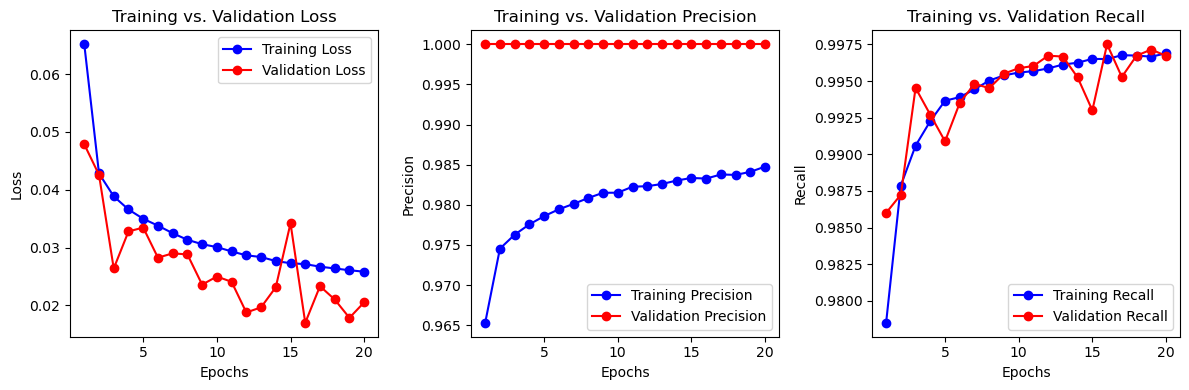

In [36]:
def plot_learning_curves(history):
    # Extract metrics from training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Precision
    plt.subplot(1, 3, 2)
    plt.plot(epochs, precision, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
    plt.title('Training vs. Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Training vs. Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_learning_curves(history)

2814/2814 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step

Test Evaluation:
                    precision    recall  f1-score   support

No Hospitalization       1.00      1.00      1.00     89999
   Hospitalization       0.08      0.25      0.12        44

          accuracy                           1.00     90043
         macro avg       0.54      0.62      0.56     90043
      weighted avg       1.00      1.00      1.00     90043

ROC-AUC: 0.624


/tmp/ipykernel_21165/839485512.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


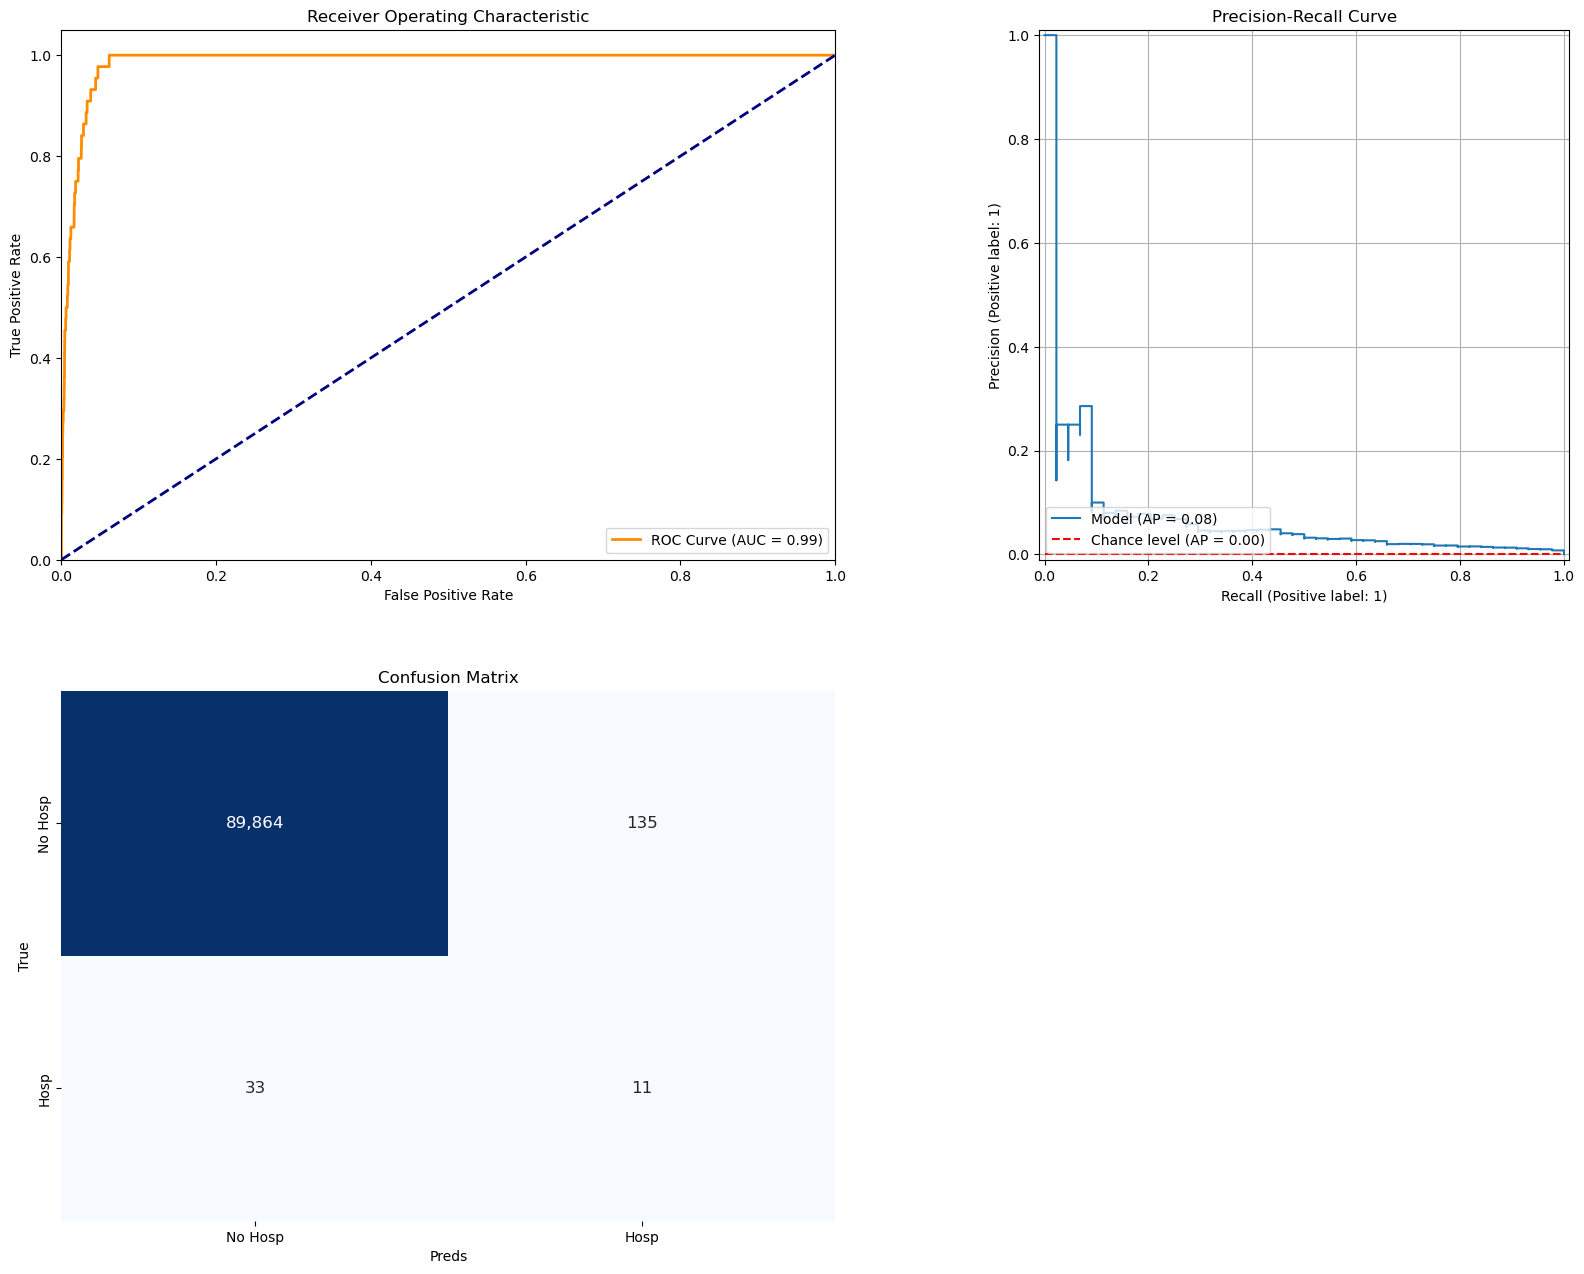

In [37]:
probabilities = model.predict(X_test)
predicted_labels = (probabilities > 0.5).astype(int)  # Threshold at 0.5

# 6. Key metrics
print("\nTest Evaluation:")
print(classification_report(test['target'], predicted_labels, target_names=['No Hospitalization', 'Hospitalization']))

# print(f"\nAUPRC: {average_precision_score(test['target'], predicted_labels):.3f}")
print(f"ROC-AUC: {roc_auc_score(test['target'], predicted_labels):.3f}")

plot_evaluation_metrics(test['target'], probabilities, predicted_labels, model)